In [1]:
import os, sys
import numpy as np
import scipy.io as sio
from skimage import io
import skimage.transform
import matplotlib.pyplot as plt

sys.path.append('..')
import face3d
import trimesh
from face3d import mesh
from face3d.morphable_model import MorphabelModel

In [2]:
def create_spherical_coords_grid(resolution=512):
    theta = np.linspace(0, np.pi, resolution)  # 0 to π
    phi = np.linspace(0, 2 * np.pi, resolution)  # 0 to 2π
    theta_grid, phi_grid = np.meshgrid(theta, phi)
    return theta_grid, phi_grid

def calculate_radius(vertices, center_point):
    return np.linalg.norm(vertices - center_point, axis=1)


In [3]:
image_path = 'Data/300W_LP/IBUG/IBUG_image_003_1_0.jpg'
mat_path = 'Data/300W_LP/IBUG/IBUG_image_003_1_0.mat'
save_folder = 'single_results/posmap_300WLP_4995'

In [222]:
# uv_coords = face3d.morphable_model.load.load_uv_coords('Data/BFM/Out/BFM_UV.mat')
# uv_coords = process_uv(uv_coords, uv_h, uv_w)
bfm = MorphabelModel('Data/BFM/Out/BFM.mat')

In [223]:
info = sio.loadmat(mat_path)
shape_para = info['Shape_Para'].astype(np.float32)
exp_para = info['Exp_Para'].astype(np.float32)
vertices = bfm.generate_vertices(shape_para, exp_para)

In [224]:
faces = bfm.full_triangles

# Create a trimesh mesh object
mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

if not mesh.is_volume:
    print("Warning: The mesh is not a valid volume. This might affect proximity queries.")

In [225]:
mesh.show()

In [226]:
center_point = mesh.centroid

shift_amount_y = 0  # Adjust as needed for "up"
shift_amount_z = 0  # Adjust as needed for "forward"

# Shift the center point
center_point = center_point + [0, shift_amount_y, shift_amount_z]

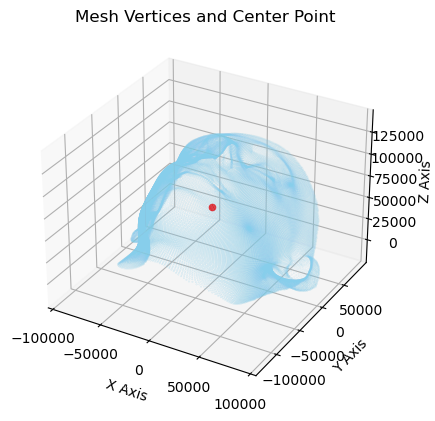

In [241]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
vertices = mesh.vertices
ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], color='skyblue', s=0.01)  # 's' controls the size of the points
ax.scatter(center_point[0], center_point[1], center_point[2], color='red', s=20)  # Red color and larger size for the center point
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Mesh Vertices and Center Point')
plt.show()

In [228]:
# Translate the vertices to the center point
translated_vertices = mesh.vertices - center_point

# Convert to spherical coordinates
spherical_coords = np.array([np.linalg.norm(vertex) for vertex in translated_vertices])
latitudes = np.arcsin(translated_vertices[:, 2] / spherical_coords)
longitudes = np.arctan2(translated_vertices[:, 1], translated_vertices[:, 0])

# Get the min and max of latitudes and longitudes (later either use whole dataset min/max or just this mesh and find a way to scale)
min_latitude, max_latitude = latitudes.min(), latitudes.max()
min_longitude, max_longitude = longitudes.min(), longitudes.max()

# Now use these min and max values to create your grid
num_points = 128  # resolution of pos map
latitudes = np.linspace(min_latitude, max_latitude, num=num_points)
longitudes = np.linspace(min_longitude, max_longitude, num=num_points)

# Convert spherical coordinates to Cartesian
radius = 1  # for a unit sphere
grid_points = np.array([[radius * np.cos(lat) * np.cos(lon), 
                         radius * np.cos(lat) * np.sin(lon), 
                         radius * np.sin(lat)] 
                        for lat in latitudes for lon in longitudes])

grid_points += center_point  # translate to the center of the mesh

In [229]:
# Calculate the directions of the rays
directions = grid_points - center_point

# Perform ray-mesh intersection
locations, index_ray, index_tri = mesh.ray.intersects_location(ray_origins=np.array([center_point]*len(directions)), ray_directions=directions)

In [230]:
distances = np.linalg.norm(locations - center_point, axis=1)

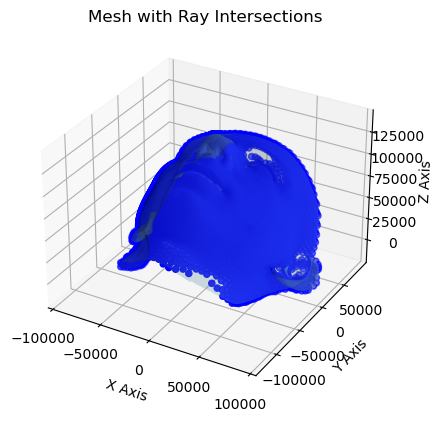

In [231]:
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Visualize the mesh
ax.plot_trisurf(vertices[:, 0], vertices[:, 1], faces, vertices[:, 2], color='skyblue', alpha=0.3)

intersected_directions = directions[index_ray]
scaled_directions = intersected_directions * distances[:, None]

# Plot rays
# for direction, location in zip(scaled_directions, locations):
#     ray_end = center_point + direction
#     ax.plot([center_point[0], ray_end[0]], [center_point[1], ray_end[1]], [center_point[2], ray_end[2]], 'r-')  # red line for rays

# Plot intersection points
ax.scatter(locations[:, 0], locations[:, 1], locations[:, 2], color='blue')  # blue dots for intersections
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('Mesh with Ray Intersections')
plt.show()

In [232]:
max_distance = distances.max()
normalized_distances = distances / max_distance

In [233]:
image_size = 128  # Assuming 64x64 resolution, adjust as needed
position_map = np.zeros((image_size, image_size))

In [234]:
# Map the intersection points to the image grid
for index, direction in enumerate(directions[index_ray]):
    # Normalize theta and phi to the image grid size
    phi = np.arcsin(direction[2] / np.linalg.norm(direction))
    theta = np.arctan2(direction[1], direction[0])

    # Convert to grid coordinates
    x = int((theta - min_longitude) / (max_longitude - min_longitude) * (image_size - 1))
    y = int((phi - min_latitude) / (max_latitude - min_latitude) * (image_size - 1))

    # Assign the normalized distance to the corresponding pixel
    position_map[y, x] = normalized_distances[index]

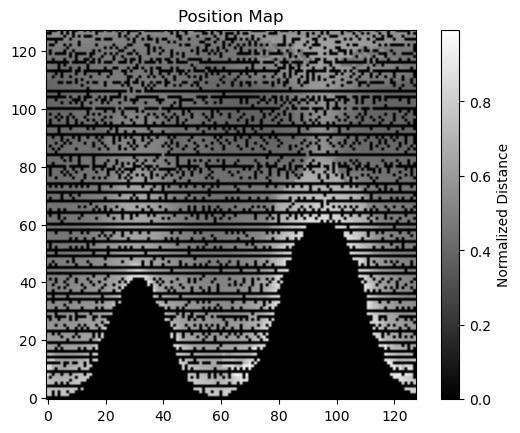

In [235]:
# Display the position map
plt.imshow(position_map, cmap='gray', origin='lower')
plt.colorbar(label='Normalized Distance')
plt.title('Position Map')
plt.show()

In [236]:
num_latitudes, num_longitudes = position_map.shape
latitudes = np.linspace(min_latitude, max_latitude, num=num_latitudes)
longitudes = np.linspace(min_longitude, max_longitude, num_longitudes)

In [237]:
points_3d = []
for i, lat in enumerate(latitudes):
    for j, lon in enumerate(longitudes):
        # Convert normalized distance back to actual distance
        distance = position_map[i, j] * max_distance
        # Convert spherical coordinates back to Cartesian coordinates
        x = distance * np.cos(lat) * np.cos(lon)
        y = distance * np.cos(lat) * np.sin(lon)
        z = distance * np.sin(lat)
        # Reconstruct the 3D point
        point_3d = center_point + np.array([x, y, z])
        points_3d.append(point_3d)

In [238]:
points_3d = np.array(points_3d)

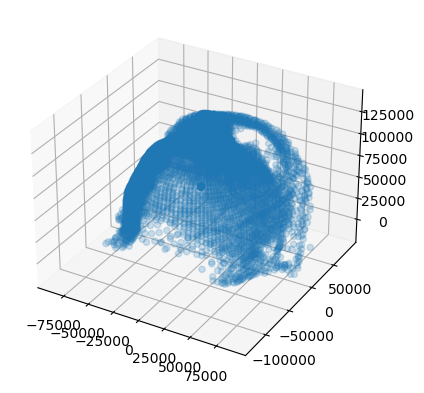

In [240]:
point_cloud = trimesh.points.PointCloud(points_3d)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.plot_trisurf(vertices[:, 0], vertices[:, 1], faces, vertices[:, 2], color='pink', alpha=0.3)
ax.scatter(point_cloud.vertices[:, 0], point_cloud.vertices[:, 1], point_cloud.vertices[:, 2], alpha=0.2)
plt.show()